# Read in the Raw Data, Load the YAML metadata, and Clean the Data

In [1]:
# Import the required modules

import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [2]:
# Read in the raw CSV data, and then print the count of observations and variables
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_1321_puf.csv

raw_df = pd.read_csv('nsmo_v50_1321_puf.csv')
raw_df.shape

(50542, 543)

In [3]:
# Load YAML files containing metadata into Python as dictionaries

# Load the labels of each variable into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_labels.sas

with open('variable_labels.yaml', 'r') as file:
    variable_labels_dict = yaml.safe_load(file)
    
# Load the the format of each variable into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_labels.sas

with open('variable_formats.yaml', 'r') as file:
    variable_formats_dict = yaml.safe_load(file)
    
# Load the categories for every categorical variable (exclude null categories) into a dictionary
# https://www.fhfa.gov/sites/default/files/2024-06/nsmo_v50_formats.sas

with open('categorical_variables_categories.yaml', 'r') as file:
    categorical_variables_categories_dict = yaml.safe_load(file)

In [4]:
# Clean data by converting negative values and "." values (representing missing values) into null values (i.e., NaN)

for col in raw_df.columns:
    # Exclude the Mortgage Performance Status variables because they have letters representing specific categories
    if variable_formats_dict[col] != 'PSTATFM':
        raw_df.loc[raw_df[col] < 0, col] = np.nan
        raw_df.loc[raw_df[col] == ".", col] = np.nan

In [5]:
# Check out a few obs after data cleaning

raw_df.tail()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.0,34.0,2117.79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,64.0,61.0,59.0,59.0,59.0,59.0,59.0,60.0
50538,546643.0,34.0,1738.92,3.0,3.0,2.0,2.0,2.0,1.0,3.0,...,NaN,NaN,79.0,77.0,74.0,72.0,72.0,71.0,71.0,71.0
50539,512993.0,34.0,2353.26,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,NaN,NaN,95.0,91.0,88.0,85.0,84.0,84.0,83.0,82.0
50540,518631.0,34.0,5283.75,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,56.0,53.0,50.0,49.0,49.0,49.0,48.0,48.0
50541,544740.0,34.0,1738.92,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,NaN,NaN,80.0,74.0,69.0,66.0,65.0,64.0,63.0,63.0


In [6]:
# Create a set of all variable formats

variable_formats_set = set(variable_formats_dict.values())

In [7]:
# Create a list of the categorical variables and a list of the numeric variables

categorical_variables = []
numeric_variables = []

categorical_variable_formats = set(categorical_variables_categories_dict.keys())
numeric_variable_formats = variable_formats_set - categorical_variable_formats

for col in raw_df.columns:
    if variable_formats_dict[col] in categorical_variable_formats:
        categorical_variables.append(col)
    elif variable_formats_dict[col] in numeric_variable_formats:
        numeric_variables.append(col)
    else:
        print("Error in bifurcation")

In [8]:
raw_df.tail()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.0,34.0,2117.79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,64.0,61.0,59.0,59.0,59.0,59.0,59.0,60.0
50538,546643.0,34.0,1738.92,3.0,3.0,2.0,2.0,2.0,1.0,3.0,...,NaN,NaN,79.0,77.0,74.0,72.0,72.0,71.0,71.0,71.0
50539,512993.0,34.0,2353.26,1.0,2.0,2.0,2.0,2.0,1.0,2.0,...,NaN,NaN,95.0,91.0,88.0,85.0,84.0,84.0,83.0,82.0
50540,518631.0,34.0,5283.75,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,56.0,53.0,50.0,49.0,49.0,49.0,48.0,48.0
50541,544740.0,34.0,1738.92,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,NaN,NaN,80.0,74.0,69.0,66.0,65.0,64.0,63.0,63.0


In [9]:
# Check out a few obs for just the categorical variable

raw_df[categorical_variables].tail()

,x05a,x05b,x05c,x05d,x05e,x05f,x05g,x06,x07,x08a,...,forb0621,forb0921,forb1221,forb0322,forb0622,forb0922,forb1222,forb0323,forb0623,forb0923
50537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0
50538,3.0,3.0,2.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,...,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0
50539,1.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0
50540,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0
50541,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,...,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [10]:
# Check out a few obs for just the numeric variable

raw_df[numeric_variables].tail()

,nsmoid,survey_wave,analysis_weight,x74r,rate_spread,pmms,term,ltv,cltv,dti,...,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222,mtmltv0323,mtmltv0623,mtmltv0923
50537,531289.0,34.0,2117.79,57.0,0.64,3.11,40.0,64.0,64.0,42.0,...,NaN,NaN,64.0,61.0,59.0,59.0,59.0,59.0,59.0,60.0
50538,546643.0,34.0,1738.92,37.0,0.03,3.10,30.0,79.0,79.0,33.0,...,NaN,NaN,79.0,77.0,74.0,72.0,72.0,71.0,71.0,71.0
50539,512993.0,34.0,2353.26,26.0,NaN,3.10,30.0,95.0,95.0,35.0,...,NaN,NaN,95.0,91.0,88.0,85.0,84.0,84.0,83.0,82.0
50540,518631.0,34.0,5283.75,36.0,NaN,3.10,20.0,56.0,56.0,46.0,...,NaN,NaN,56.0,53.0,50.0,49.0,49.0,49.0,48.0,48.0
50541,544740.0,34.0,1738.92,42.0,0.08,3.05,30.0,80.0,80.0,20.0,...,NaN,NaN,80.0,74.0,69.0,66.0,65.0,64.0,63.0,63.0


In [11]:
# View survey answers for any given observation in a human readable format using the YAML metadata
# Deactivated code below because it will print 500+ lines because we have 500+ variables

if False:
    one_obs = raw_df.iloc[50541]
    # Loop through all columns for one obs
    for col, value in one_obs.items():
        # if it's a categorical variable, then look up the category
        if not(pd.isna(value)) and col in categorical_variables:
            print(variable_labels_dict[col], ":", categorical_variables_categories_dict[variable_formats_dict[col]][value])
        # else it's a numeric variable or null
        else:
            print(variable_labels_dict[col], ":", value)

# Process the Data using Dummy Coding, Partitioning, and then Imputing

In [12]:
# Create dummy variables for each category for each categorical variable

processed_df = pd.get_dummies(raw_df, columns=categorical_variables)

In [13]:
# Remove the ".0" in many of the dummy variable due to the columns in the raw data being floats

new_columns_list = []
for col in processed_df.columns:
    new_col = col.replace(".0", "")
    new_columns_list.append(new_col)
    
processed_df.columns = new_columns_list

In [14]:
# Retrieve the names of the new categorical variables (i.e., the dummy variables)

new_categorical_variables = []
for col in processed_df.columns:
    if col not in numeric_variables:
        new_categorical_variables.append(col)

In [15]:
# Check out a few obs for just the new categorical variable

processed_df[new_categorical_variables].tail()

,x05a_1,x05a_2,x05a_3,x05b_1,x05b_2,x05b_3,x05c_1,x05c_2,x05c_3,x05d_1,...,forb0922_1,forb0922_2,forb1222_1,forb1222_2,forb0323_1,forb0323_2,forb0623_1,forb0623_2,forb0923_1,forb0923_2
50537,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1
50538,0,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
50539,1,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
50540,0,0,1,0,0,1,0,0,1,0,...,0,1,0,1,0,1,0,1,0,1
50541,1,0,0,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1


In [16]:
# Identify the target variable

target_variable = 'rate_spread'

In [17]:
# List the NSMO variables to be excluded

list_of_NSMO_variables = ['nsmoid',         # NSMO Identification Number
                          'survey_wave',    # NSMO Survey Wave (Quarterly)
                          'analysis_weight' # NSMO Analysis Weight (Sampling Weight x Non-response Adjustment)
                         ]

In [18]:
# Create a compete list of all excluded variables, which includes the target variable and the NSMO variables

list_of_excluded_variables = list([target_variable]) + list_of_NSMO_variables
print(list_of_excluded_variables)

['rate_spread', 'nsmoid', 'survey_wave', 'analysis_weight']


In [19]:
# Calculate the percentage of missing values in the target variable

sum_of_missing_values_in_target = processed_df[target_variable].isna().sum()
print("sum of missing values in target: ", sum_of_missing_values_in_target, 
      "\ntotal observations in data: ", processed_df.shape[0], 
      "\npercentage of target with missing values: ", round(sum_of_missing_values_in_target / processed_df.shape[0] * 100,1), "%")

sum of missing values in target:  16379 
total observations in data:  50542 
percentage of target with missing values:  32.4 %


In [20]:
# Drop observations in the data where the target variable has missing values

processed_df = processed_df.dropna(subset=target_variable)

In [21]:
# Segregate the predictor variables from the target variable

X = processed_df.drop(columns=list_of_excluded_variables)
y = processed_df[target_variable]

In [22]:
# Split the data into training and testing partitions

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=0)

In [23]:
# Impute missing values for the predictor variables using the mean values

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Prevent "data leakage" by fitting the imputer on just the training data, and then apply it to the holdout testing data
imputer.fit(X_train)

# Transform both the training and testing data using the imputer fitted on just the training data
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Supervised Learning Models: Gradient Boosting, Linear, LASSO, and Random Forest

In [24]:
# Fit a Gradient Boosting Regression model on the training partition, and then evaluate it on the testing partition
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

params = {'max_depth': 4, 'learning_rate': 0.01, 'random_state':0}
grad_boost_reg = HistGradientBoostingRegressor(**params)
grad_boost_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, grad_boost_reg.predict(X_test))
mse = mean_squared_error(y_test, grad_boost_reg.predict(X_test))
rmse = np.sqrt(mse)
grad_boost_reg_dict = {"model": "Gradient Boosting Regression", 
                       "Mean Absolute Error": mae, 
                       "Root Mean Squared Error": rmse}

In [25]:
# Fit a Linear Model on the training partition, and evaluate it on the testing partition
# There is a lot of Multicollinearity in this model because we are putting all predictor variables into the model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,y_train)

mae = mean_absolute_error(y_test, linear_reg.predict(X_test))
mse = mean_squared_error(y_test, linear_reg.predict(X_test))
rmse = np.sqrt(mse)
linear_reg_dict = {"model": "Linear Regression", 
                   "Mean Absolute Error": mae, 
                   "Root Mean Squared Error": rmse}

In [26]:
# Fit a LASSO regression on the training partition, and then evaluate it on the testing partition
# This will shrink most of the variable coefficients to zero for automated variable selection
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

linear_reg_with_lasso = linear_model.Lasso(alpha=0.1)
linear_reg_with_lasso.fit(X_train,y_train)

mae = mean_absolute_error(y_test, linear_reg_with_lasso.predict(X_test))
mse = mean_squared_error(y_test, linear_reg_with_lasso.predict(X_test))
rmse = np.sqrt(mse)
lasso_reg_dict = {"model": "LASSO Regression", 
                   "Mean Absolute Error": mae, 
                   "Root Mean Squared Error": rmse}

In [27]:
# Use the LASSO regression to identify the most useful variable to predict the target (i.e., the variables whose coefficient didn't shrink to zero)

variable_names = list(X.columns) 
linear_reg_with_lasso_coef = linear_reg_with_lasso.coef_

for variable, coef in zip(variable_names, linear_reg_with_lasso_coef):
    # if the coefficient didn't shrink to zero
    if (coef != 0):
        # if it's a categorical variable
        if variable in new_categorical_variables:
            variable_substrings = variable.split("_")  # split up the new categorical variable name by underscores
            categorical_variable = '_'.join(variable_substrings[:-1])  # retrieve the original categorical variable name (e.g., 'x05a', 'perf_status_0923', etc.)
            category = variable_substrings[-1:][0]  # retrieve the category chosen for the categorical variable (e.g., '1', '10', '2013', 'A', etc.)
            if any(character.isdigit() for character in category):
                category = int(category)
            else:
                category = str(category)
            print(variable, ":", variable_labels_dict[categorical_variable], ":", categorical_variables_categories_dict[variable_formats_dict[categorical_variable]][category], ":", coef)
        # else it's a numeric variable
        else:
            print(variable, ":", variable_labels_dict[variable], ":", coef)

x74r : Age at last birthday | Respondent : 0.0009938100918393318
term : Mortgage Term (in Years) at Origination : -0.007168546119660699
ltv : Mortgage Loan-to-Value Ratio at Origination (Percent) : -0.0006840495151100318
dti : Mortgage Debt-to-Income (Back End) Ratio at Origination (Percent) : 0.0022530286821076033
pti : Mortgage Payment-to-Income (Front End) Ratio at Origination (Percent) : -0.0027014489258385074
score_orig_r : VantageScore 3.0 at Origination | Respondent : -0.0010619100883767166
score_orig_s : VantageScore 3.0 at Origination | Spouse/Partner : -0.00019052724419174513
score_orig_o1 : VantageScore 3.0 at Origination | Other Borrower 1 : -0.00044074650238460863
score_0913_r : VantageScore 3.0 in September 2013 | Respondent : 4.834260429904939e-05
score_0614_r : VantageScore 3.0 in June 2014 | Respondent : -7.2066672867654096e-06
score_0616_r : VantageScore 3.0 in June 2016 | Respondent : 5.068282710846779e-05
score_0916_r : VantageScore 3.0 in September 2016 | Responden

In [28]:
# Fit a Random Forest regression model on the training partition, and then evaluate it on the testing partition
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

params = {'n_estimators': 100, 'max_depth': 4, 'random_state':0}
random_forest_reg = RandomForestRegressor(**params)
random_forest_reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, random_forest_reg.predict(X_test))
mse = mean_squared_error(y_test, random_forest_reg.predict(X_test))
rmse = np.sqrt(mse)
random_forest_reg_dict = {"model": "Random Forest Regression", 
                          "Mean Absolute Error": mae, 
                          "Root Mean Squared Error": rmse}

In [29]:
# Use the Random Forest regression model to identify the top N most important feature based upon their respective feature importance values

top_N = 20
feature_importances = pd.Series(data=random_forest_reg.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
top_N_features = feature_importances.head(top_N)

# Print the top N feature by importance from Random Forest regression model in descending order
for variable in top_N_features.index:
    feature_importance = top_N_features[variable]
    # if the feature importance is greater than zero
    if (feature_importance > 0):
        # if it's a categorical variable
        if variable in new_categorical_variables:
            variable_substrings = variable.split("_")  # split up the new categorical variable name by underscores
            categorical_variable = '_'.join(variable_substrings[:-1])  # retrieve the original categorical variable name (e.g., 'x05a', 'perf_status_0923', etc.)
            category = variable_substrings[-1:][0]  # retrieve the category chosen for the categorical variable (e.g., '1', '10', '2013', 'A', etc.)
            if any(character.isdigit() for character in category):
                category = int(category)
            else:
                category = str(category)
            print(variable, ":", variable_labels_dict[categorical_variable], ":", categorical_variables_categories_dict[variable_formats_dict[categorical_variable]][category], ":", feature_importance)
        # else it's a numeric variable
        else:
            print(variable, ":", variable_labels_dict[variable], ":", feature_importance)

x60_2 : Which one of the following best describes this property? : Mobile home or manufactured home : 0.1694468184215933
loan_amount_cat_1 : Mortgage Loan Amount at Origination (Categorical) : Less than $50,000 : 0.16223374768537396
pmms : Freddie Macs Primary Mortgage Market Survey (PMMS) Rate at Origination (Percent) : 0.06733067720711762
loan_amount_cat_2 : Mortgage Loan Amount at Origination (Categorical) : $50,000 to  $99,999 : 0.060519508055268637
term : Mortgage Term (in Years) at Origination : 0.04256064693467468
score_orig_r : VantageScore 3.0 at Origination | Respondent : 0.042373091693830106
x44_1 : Does this mortgage have... | An adjustable rate (one that can change over the life of the loan)? : Yes : 0.03772856384547527
mtmltv0920 : Mark-to-Market Loan-to-Value Ratio of the Mortgage, September 2020 : 0.03305640965630153
x66_5 : Which one of the following best describes how you use this property? : Rental or investment property : 0.028271097825727023
perf_status_0317_1 : Mo

In [30]:
# Compare the performance metrics for the various models on the holdout testing data

all_model_performance_metrics = [grad_boost_reg_dict,
                                linear_reg_dict,
                                lasso_reg_dict,
                                random_forest_reg_dict]

all_model_performance_metrics_df = pd.DataFrame(all_model_performance_metrics)
print(all_model_performance_metrics_df)

                          model  Mean Absolute Error  Root Mean Squared Error
0  Gradient Boosting Regression             0.294654                 0.490290
1             Linear Regression             0.291810                 0.502987
2              LASSO Regression             0.307849                 0.528821
3      Random Forest Regression             0.292143                 0.489412


# Unsupervised Learning: K-means Clustering

In [31]:
# Concatenate X_train and X_test as X for Unsupervised Learning

X = pd.concat([X_train, X_test], axis=0)

In [32]:
# Compute K-means Clustering from K = 1 to 10 using Mini Batches to speed up computations
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

list_of_inertia_for_each_K = []

for k in range(1, 11):
    mbk = MiniBatchKMeans(init ='k-means++', 
                          n_clusters = k,
                          batch_size = 100, 
                          n_init = 10,
                          max_no_improvement = 10, 
                          verbose = 0)

    mbk.fit(X)
    list_of_inertia_for_each_K.append(mbk.inertia_)

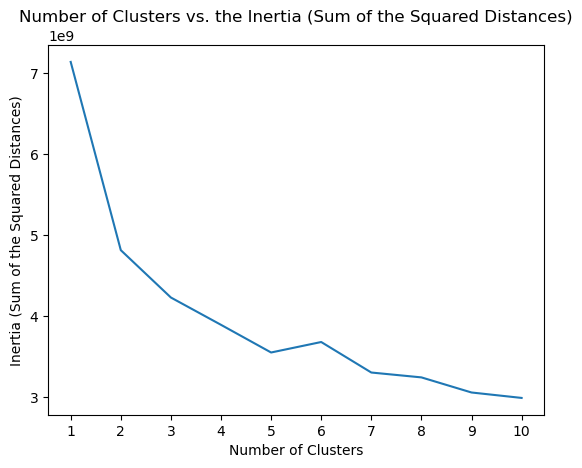

In [33]:
# Plot of the Number of Clusters vs. the Inertia of Mini Batch K-means Clustering

plt.plot(range(1, 11), list_of_inertia_for_each_K)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Sum of the Squared Distances)")
plt.title("Number of Clusters vs. the Inertia (Sum of the Squared Distances)")
plt.show()

In [34]:
# K-means Clustering with K=5 seems opimal because of the "elbow" point
# https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/

mbk = MiniBatchKMeans(init ='k-means++', 
                      n_clusters = 5,
                      batch_size = 100, 
                      n_init = 10,
                      max_no_improvement = 10, 
                      verbose = 0)

mbk.fit(X)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# Print out the cluster labels for each observation

print(mbk_means_labels)

[0 4 3 ... 3 4 2]
